In [1]:
import numpy as np
import pandas as pd

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.inference                      import elbo as elbo_py
from mrashpen.inference                      import coordinate_descent_step as cd_step
from mrashpen.models                         import mixture_gaussian as mix_gauss

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')


def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, 
                         intercept = 0, title = None):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    
def plot_convergence(objs, methods, nwarm, eps = 1e-8):
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(111)

    objmin  = np.min([np.min(x) for x in objs])

    for obj, method, iteq in zip(objs, methods, nwarm):
        m_obj = np.array(obj)[iteq:] - objmin
        m_obj = m_obj[m_obj > 0]
        ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
                 marker = 'o', markersize = 1)
    ax1.legend()

    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("log( max(ELBO) - ELBO )")

    plt.show()
    return

def plot_trendfilter_mrashpen(X, y, beta, ytest, bhat,
                              intercept = 0, title = None):
    n = y.shape[0]
    p = X.shape[1]

    ypred = np.dot(X, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(np.arange(n), ytest, edgecolor = 'black', facecolor='white')
    ax1.plot(np.arange(n), ypred)
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("Y")

    ax2.scatter(np.arange(p), beta, edgecolor = 'black', facecolor = 'white')
    ax2.scatter(np.arange(p), bhat, s = 40, color = 'firebrick')
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("b")
    
    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()
    
def linreg_summary_df(sigma2, objs, methods):
    data     = [[strue * strue,  '-', '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        if isinstance(obj.elbo_path, list) or isinstance(obj.elbo_path, np.ndarray):
            elbo = obj.elbo_path[-1]
        else:
            elbo = obj.elbo_path
        data.append([obj.residual_var, elbo, obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'ELBO', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def linreg_summary_df_noelbo(sigma2, objs, methods):
    data     = [[strue * strue, '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def get_elbos(X, y, b, w, sk, s2):
    elbo1 = cd_step.elbo(X, y, sk, b, w, s2)

    dj     = np.sum(np.square(X), axis = 0)
    r      = y - np.mean(y) - np.dot(X, b)
    btilde = b + np.dot(X.T, r) / dj
    nmash  = NormalMeansASHScaled(btilde, np.sqrt(s2), w, sk, d = dj, debug = False)
    phijk, mujk, varjk = nmash.posterior()
    elbo2  = elbo_py.scalemix(X, y, sk, b, w, s2,
                              dj = dj, phijk = phijk, mujk = mujk, varjk = varjk, eps = 1e-8)
    return elbo1, elbo2

In [21]:
n = 200
p = 2000
p_causal = 10
pve = 0.7
rho = 0.95
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = rho, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

In [22]:
'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)
winit  = mix_gauss.emfit(lasso_b, sk)
print ("Lasso initialization")

'''
mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True, 
                maxiter = 2000, tol = 1e-8, function_call = 'python')
plr_lbfgs.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)
#plr_lbfgs = lbfgsfit.method_fixseq_simple(X, y, sk, wk, binit = lasso_b, s2init = s2init, calculate_elbo = True)
#plr_lbfgs = lbfgsfit.method_init_gb(X, y, sk, wk, binit = lasso_b, s2init = s2init, calculate_elbo = True)

'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init, 
               maxiter = 200, qb_maxiter = 50, calculate_elbo = True)


'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)


'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

Lasso initialization
mr.ash.pen terminated at iteration 174.
mr.ash.pen (EM) terminated at iteration 70.
Mr.ASH terminated at iteration 405.
Mr.ASH terminated at iteration 217.


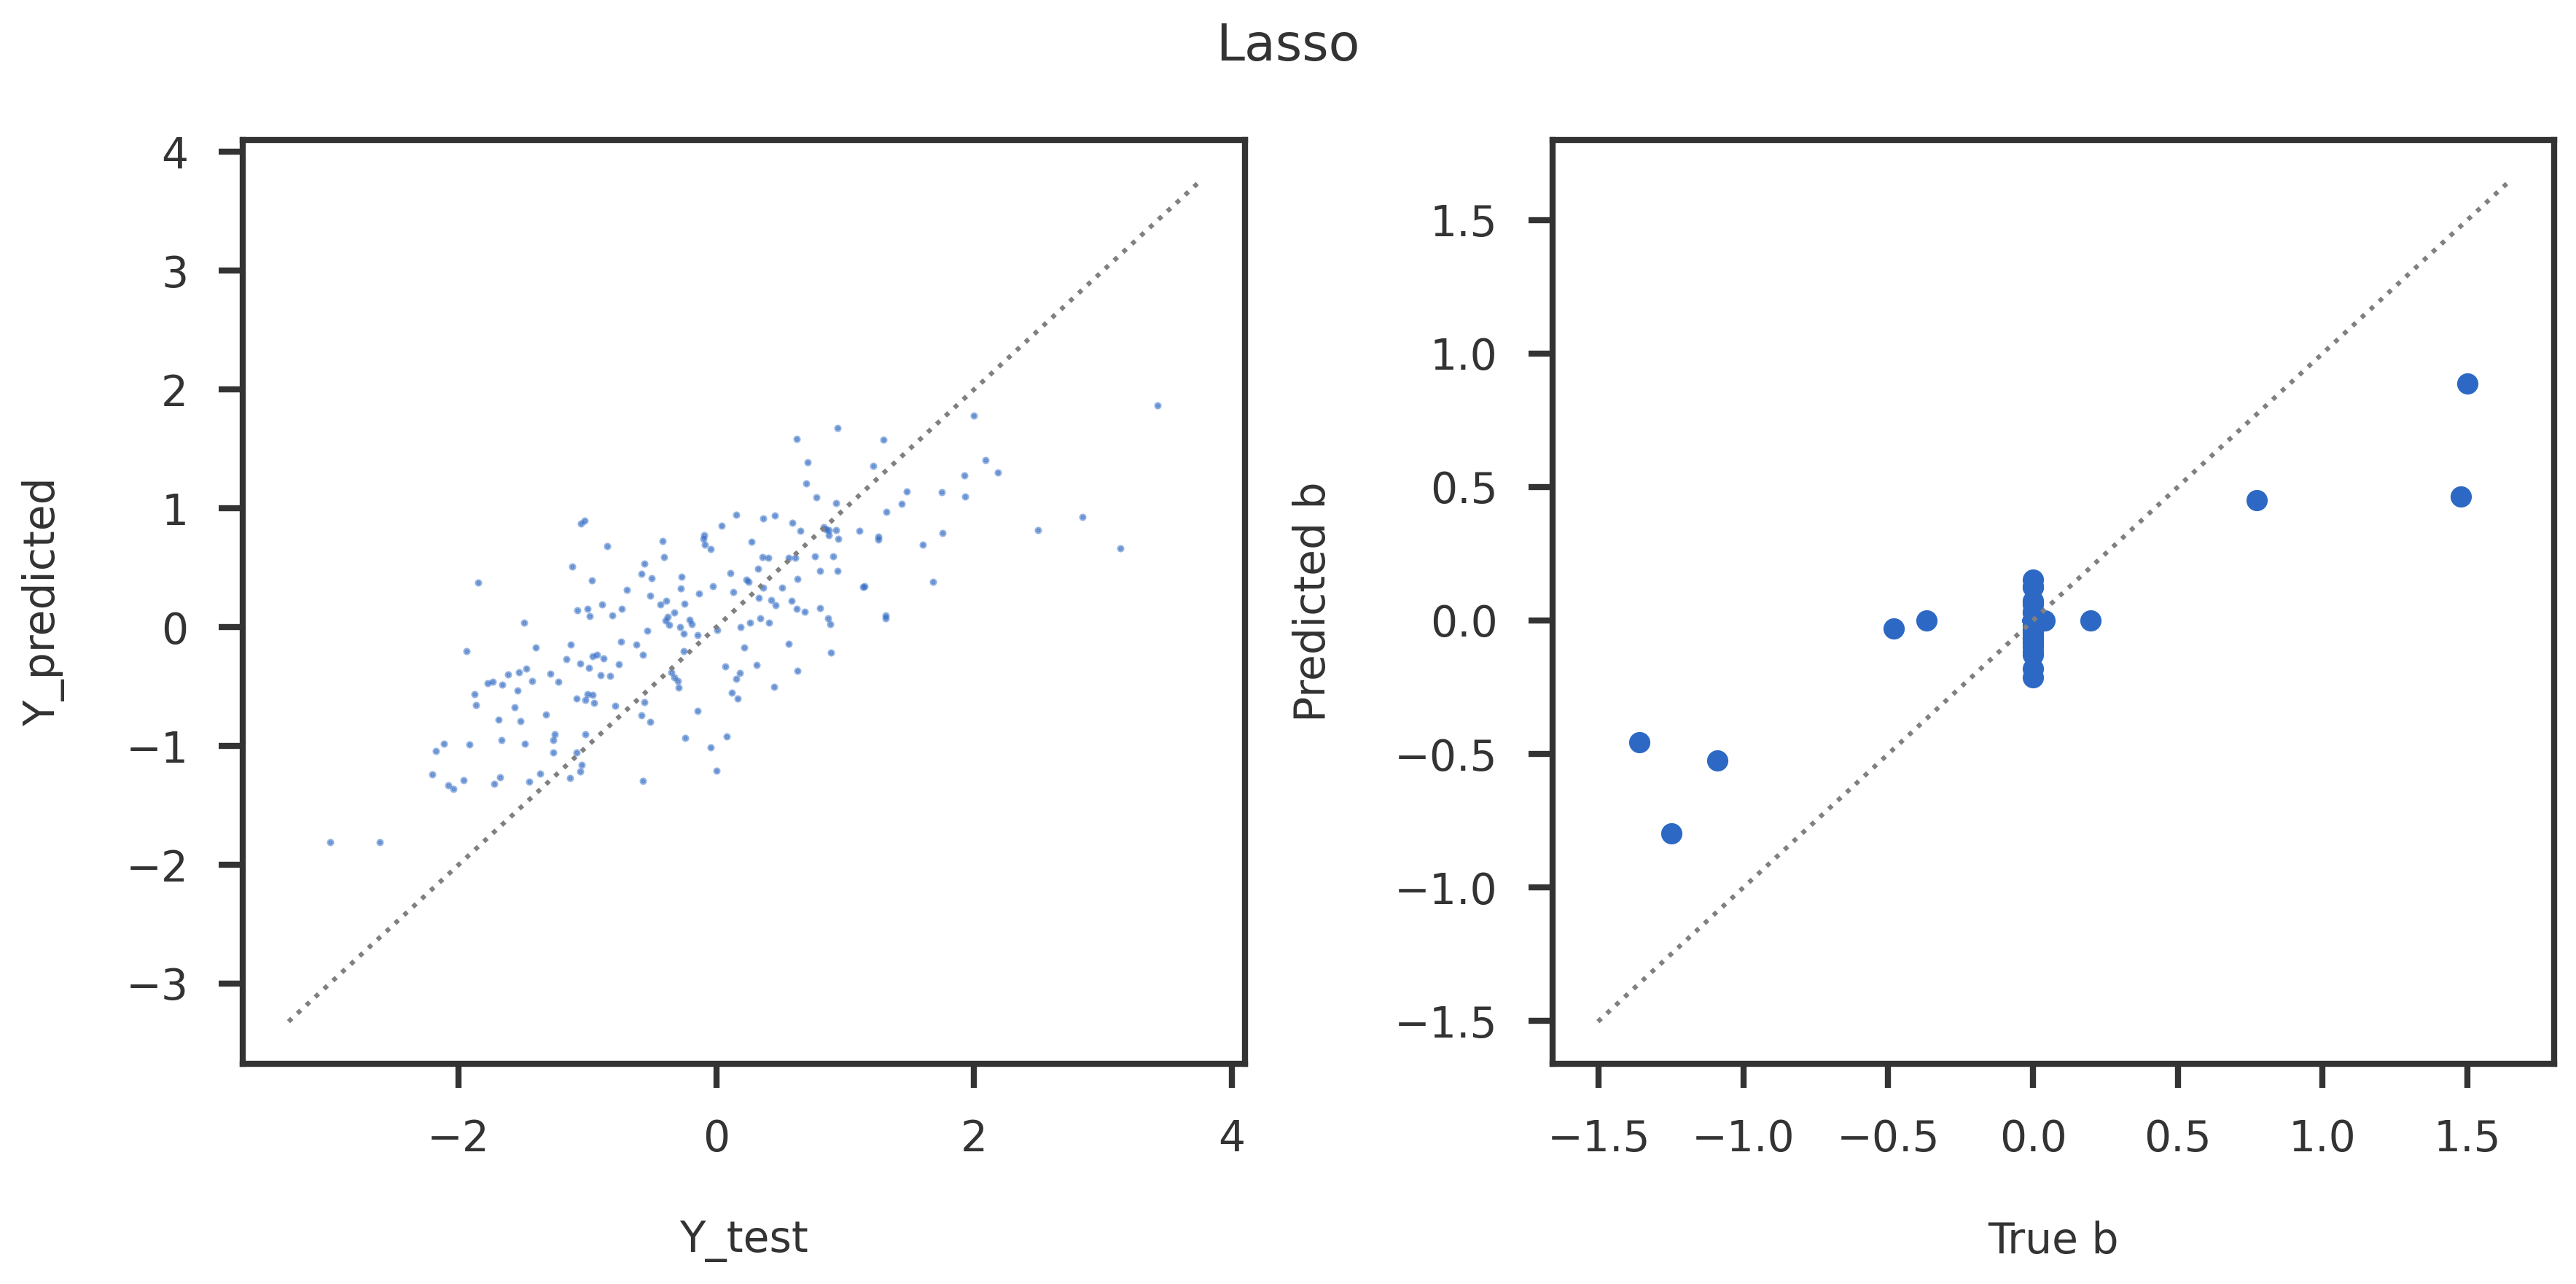

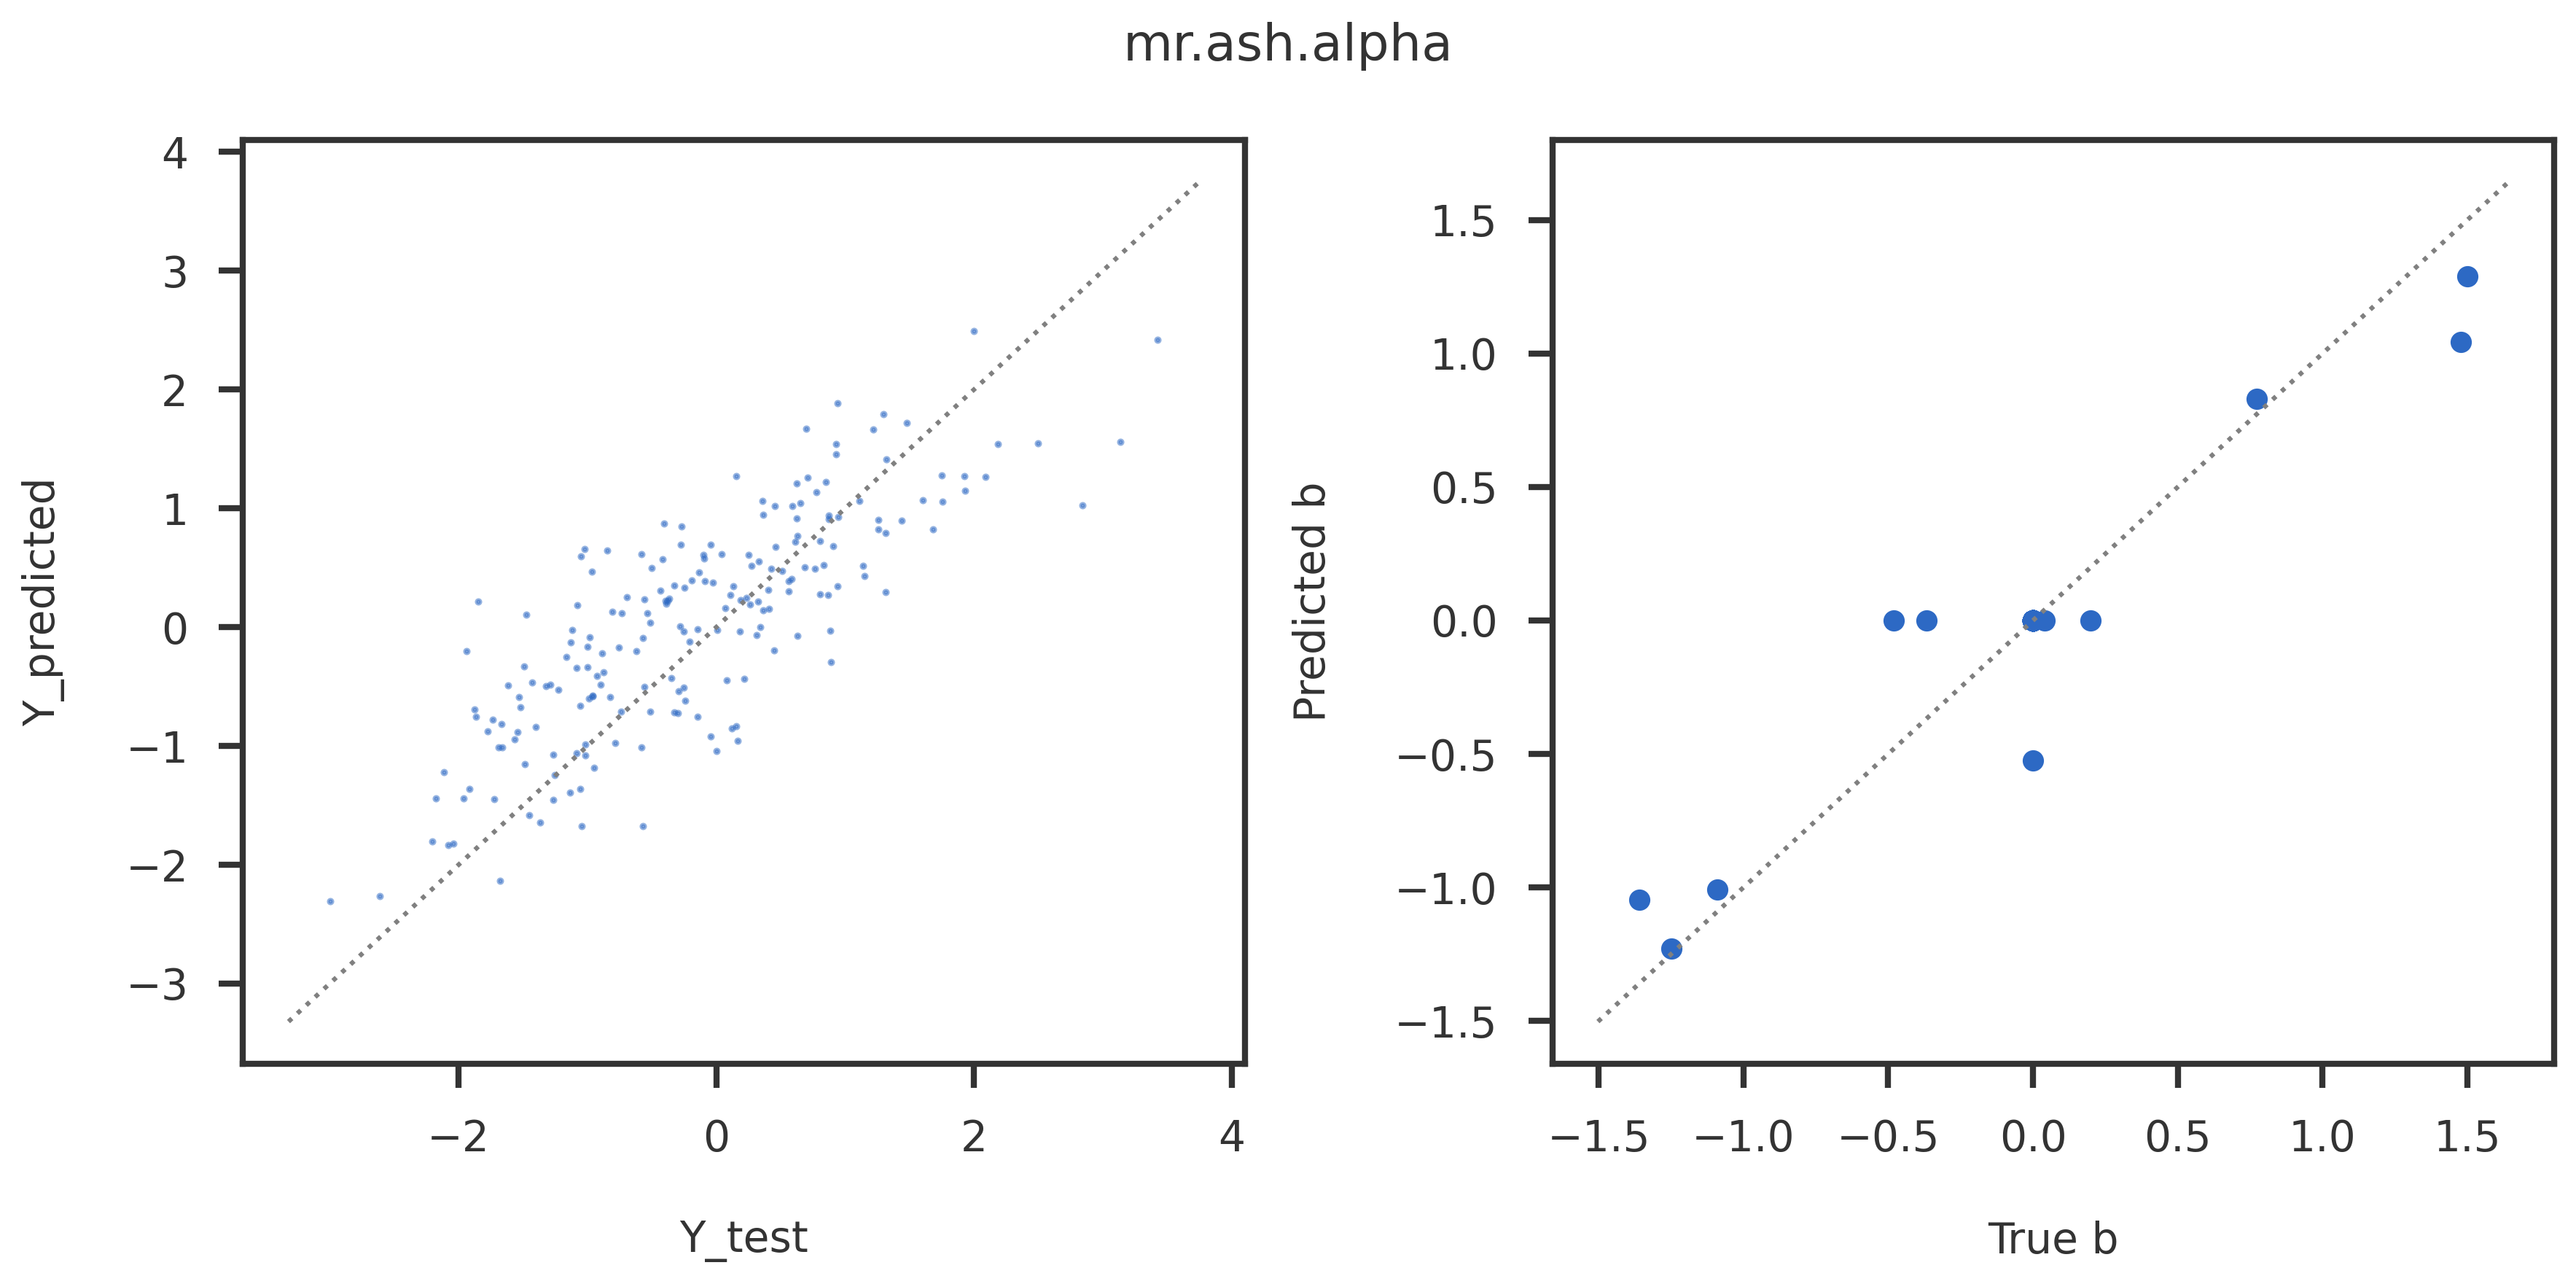

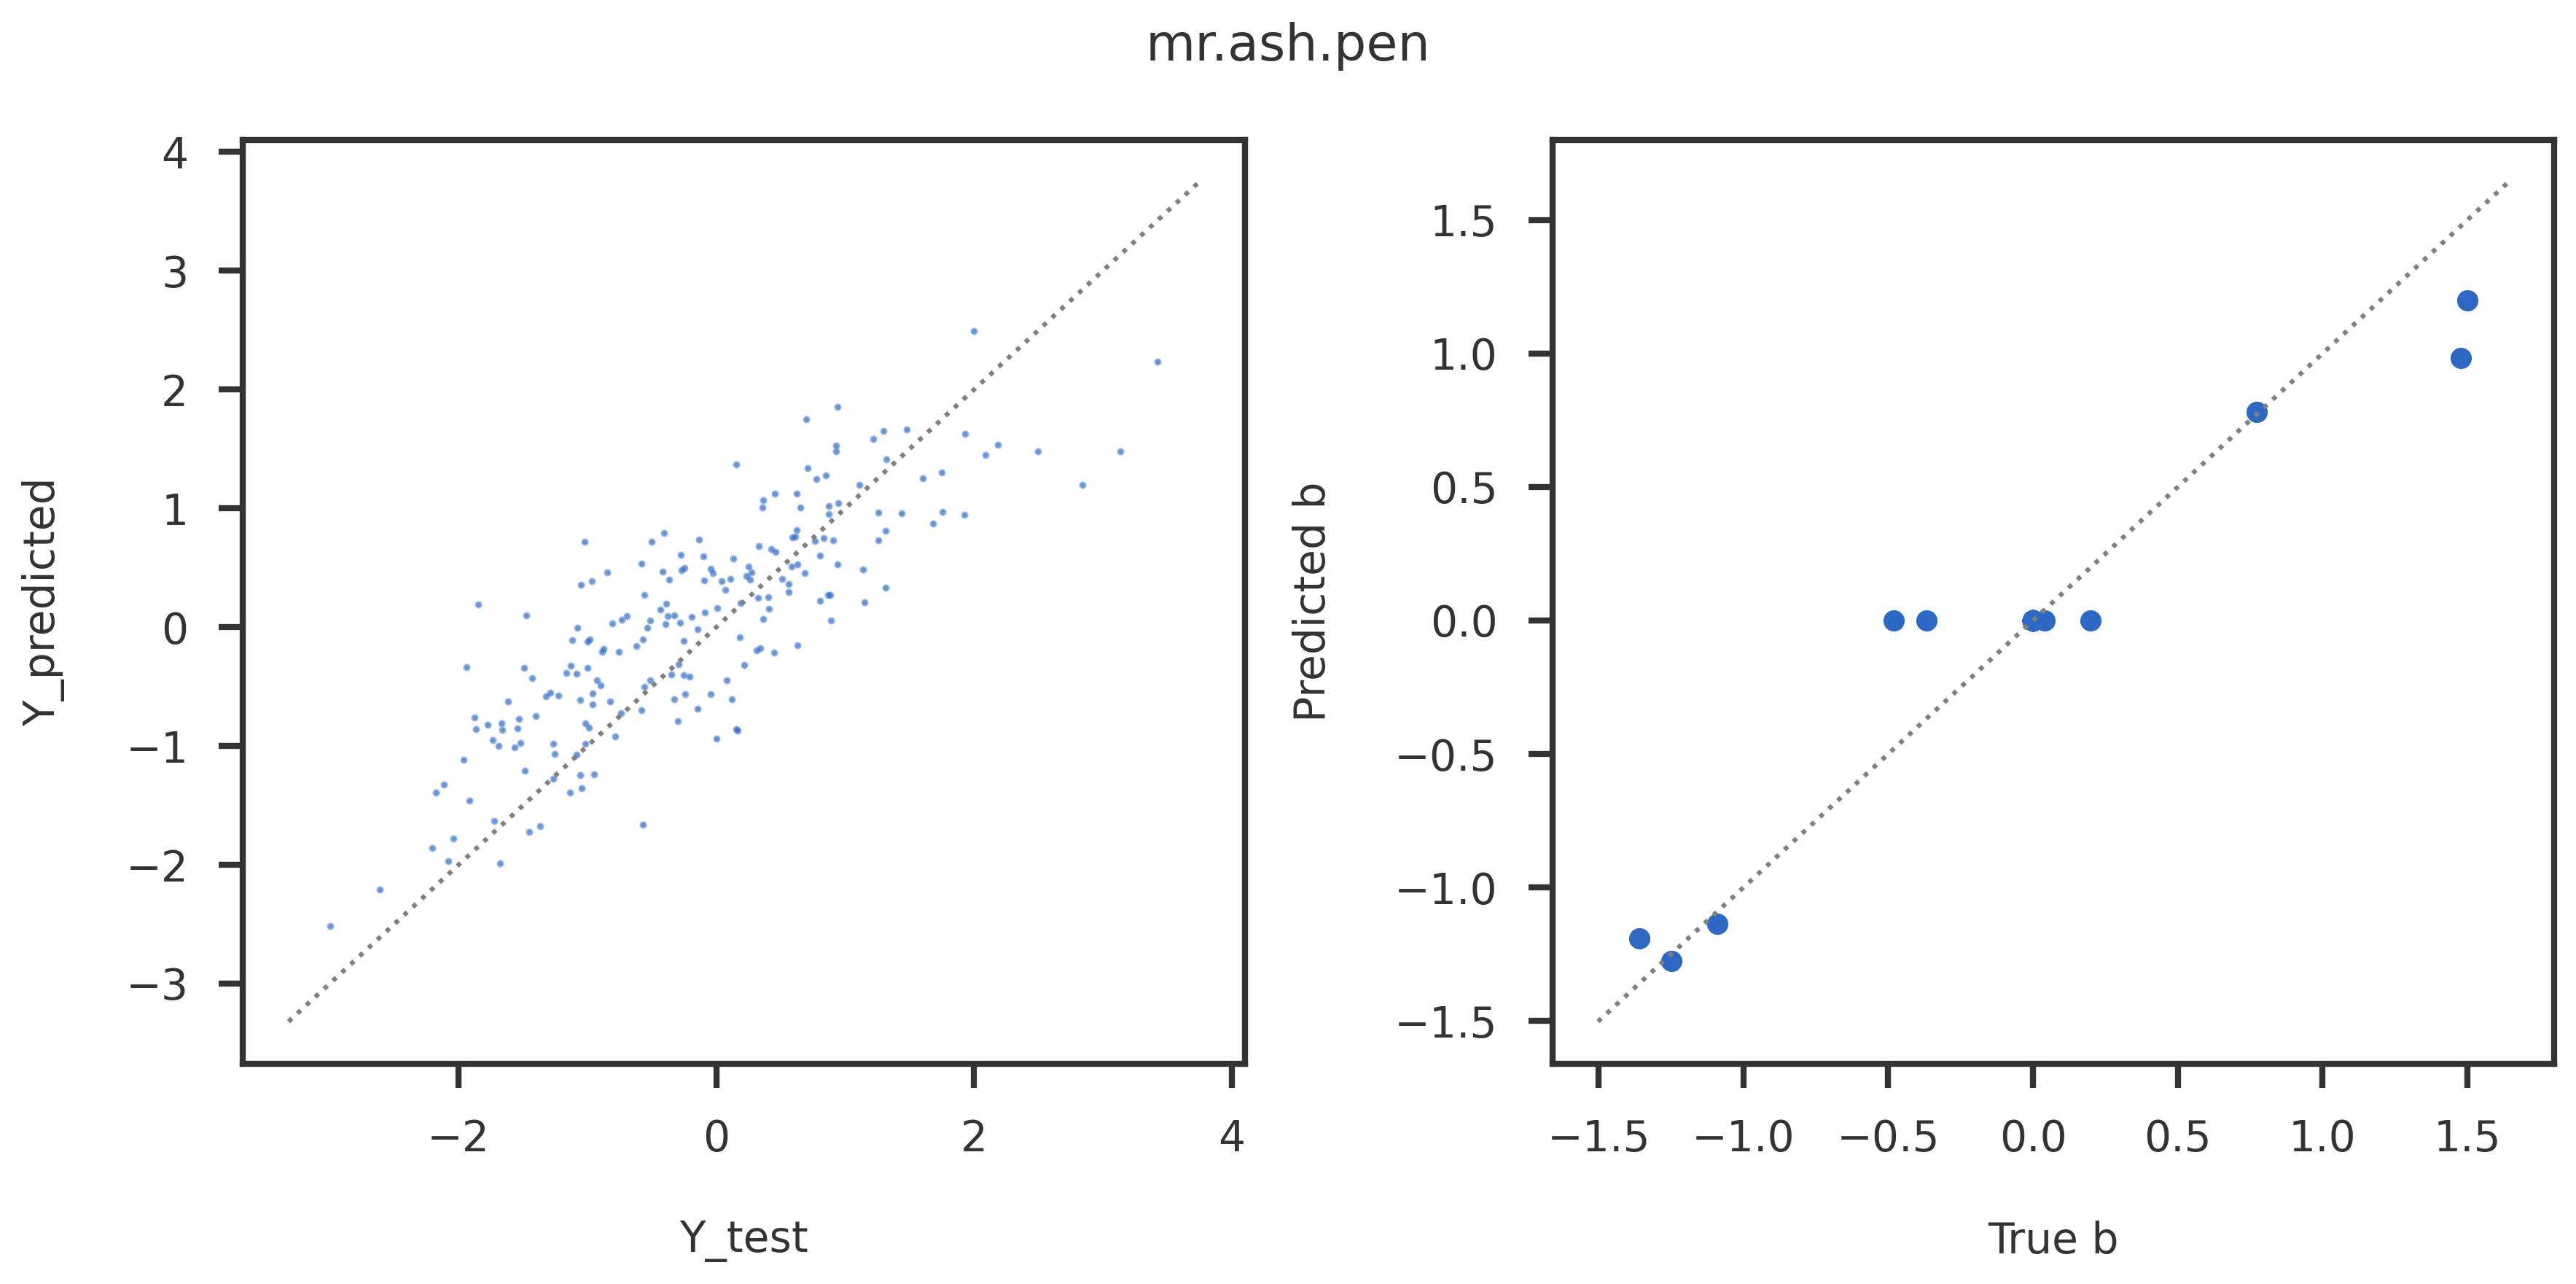

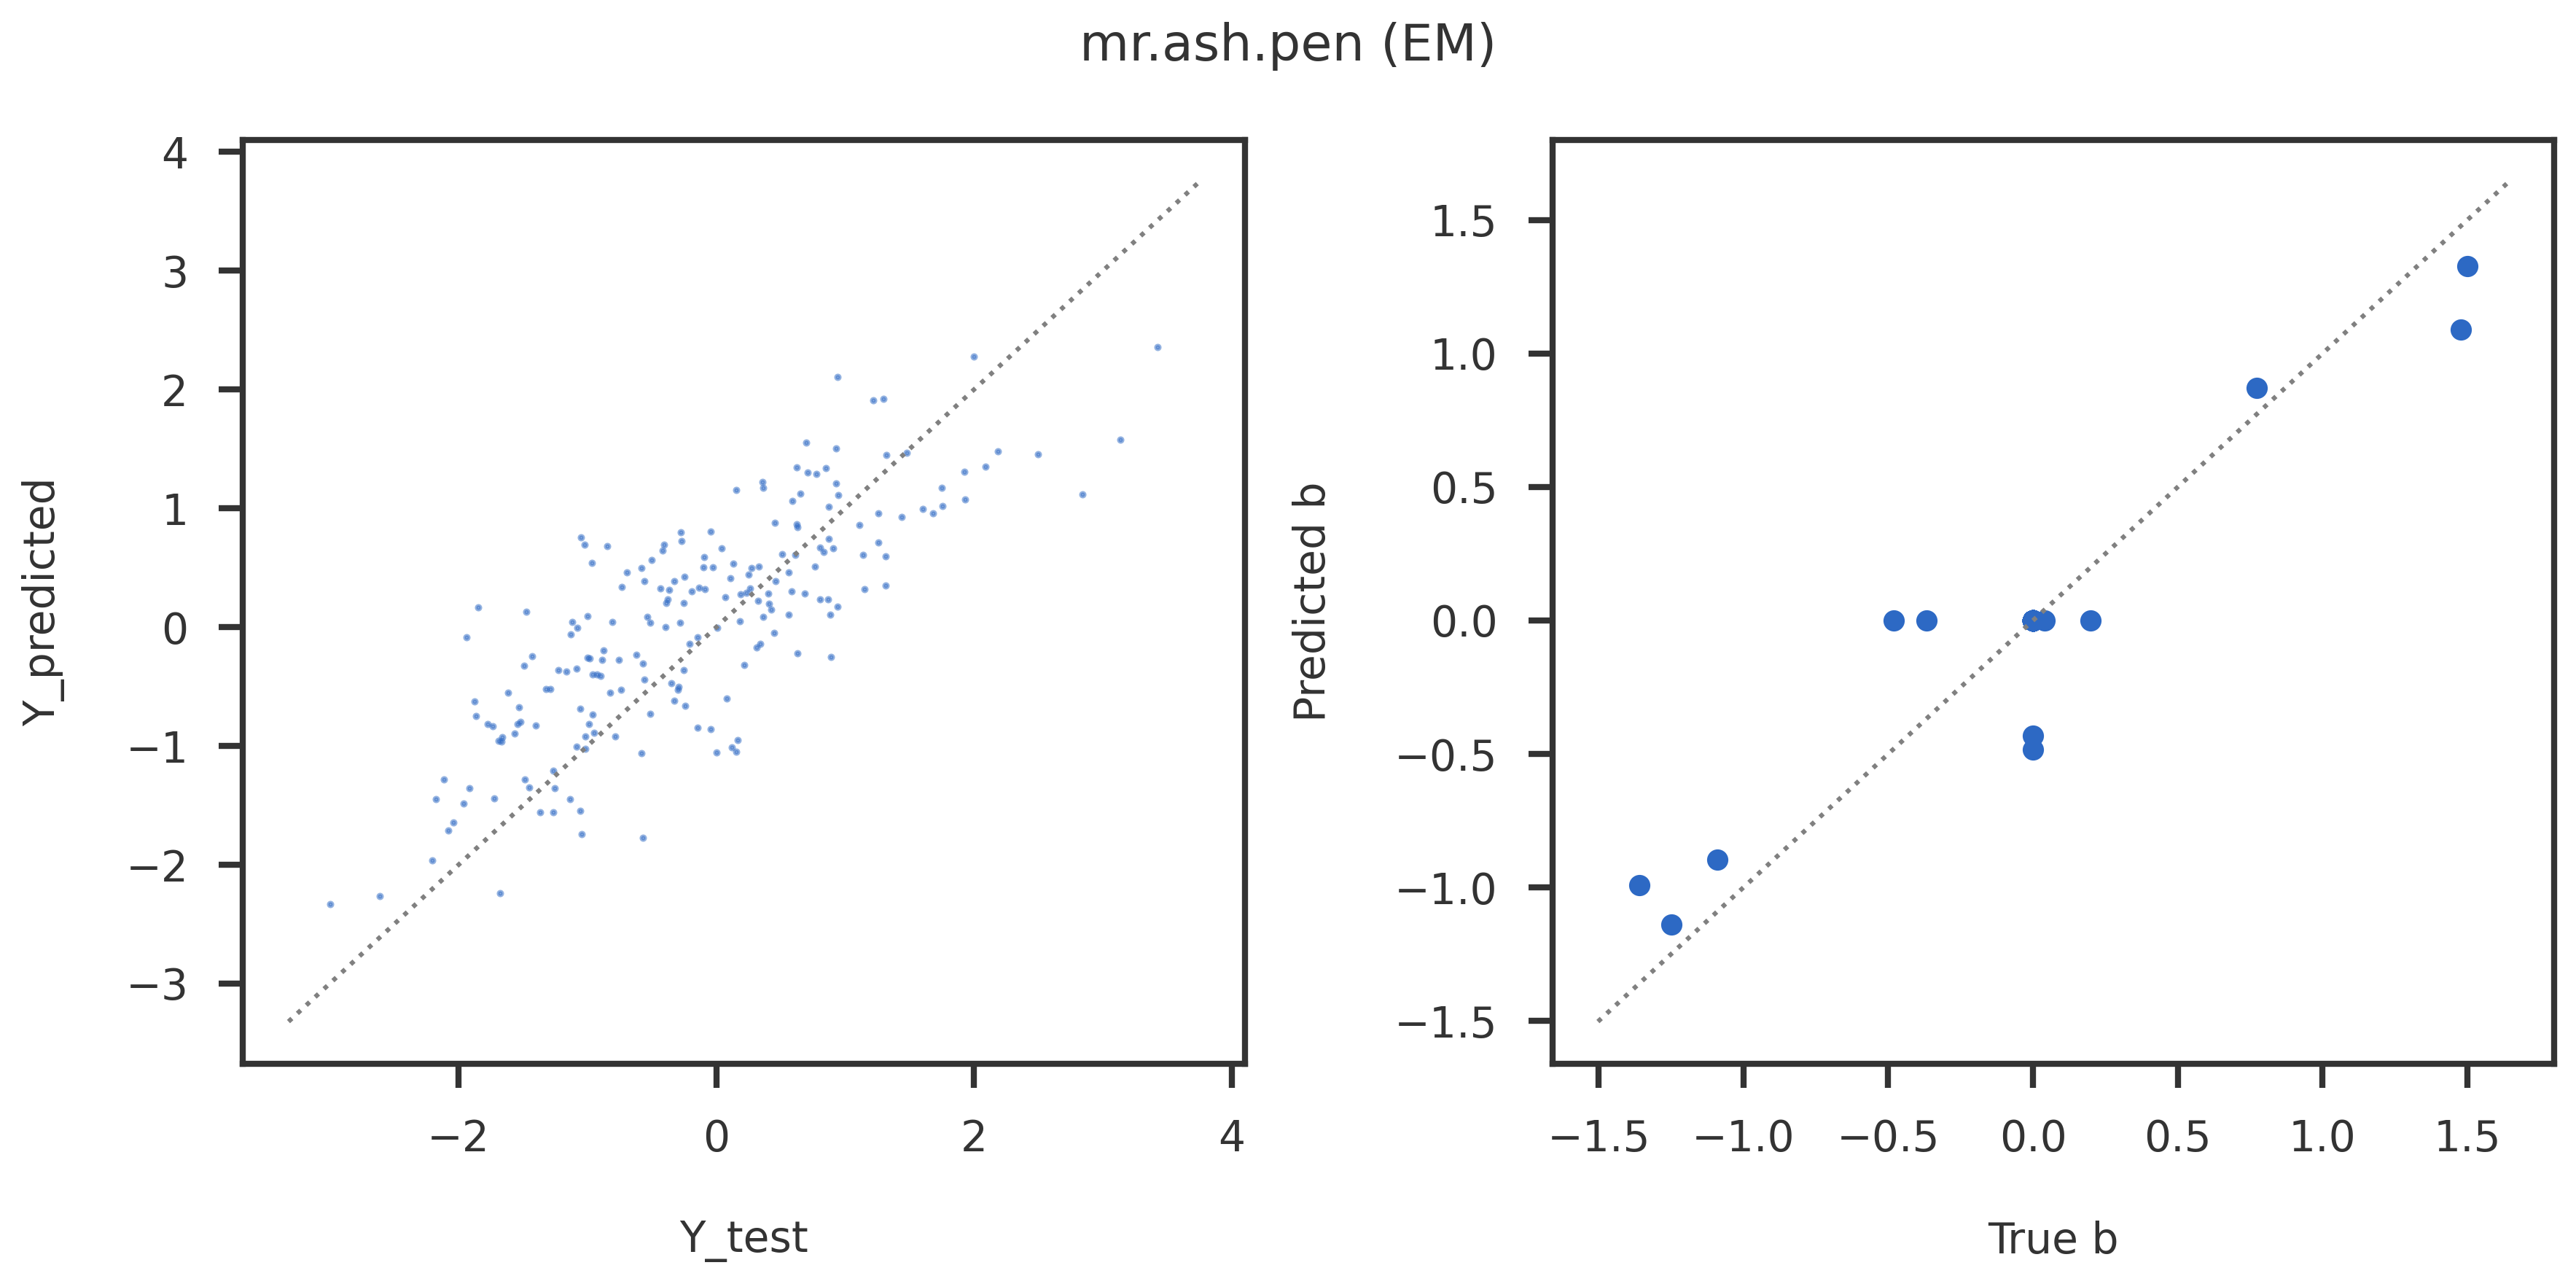

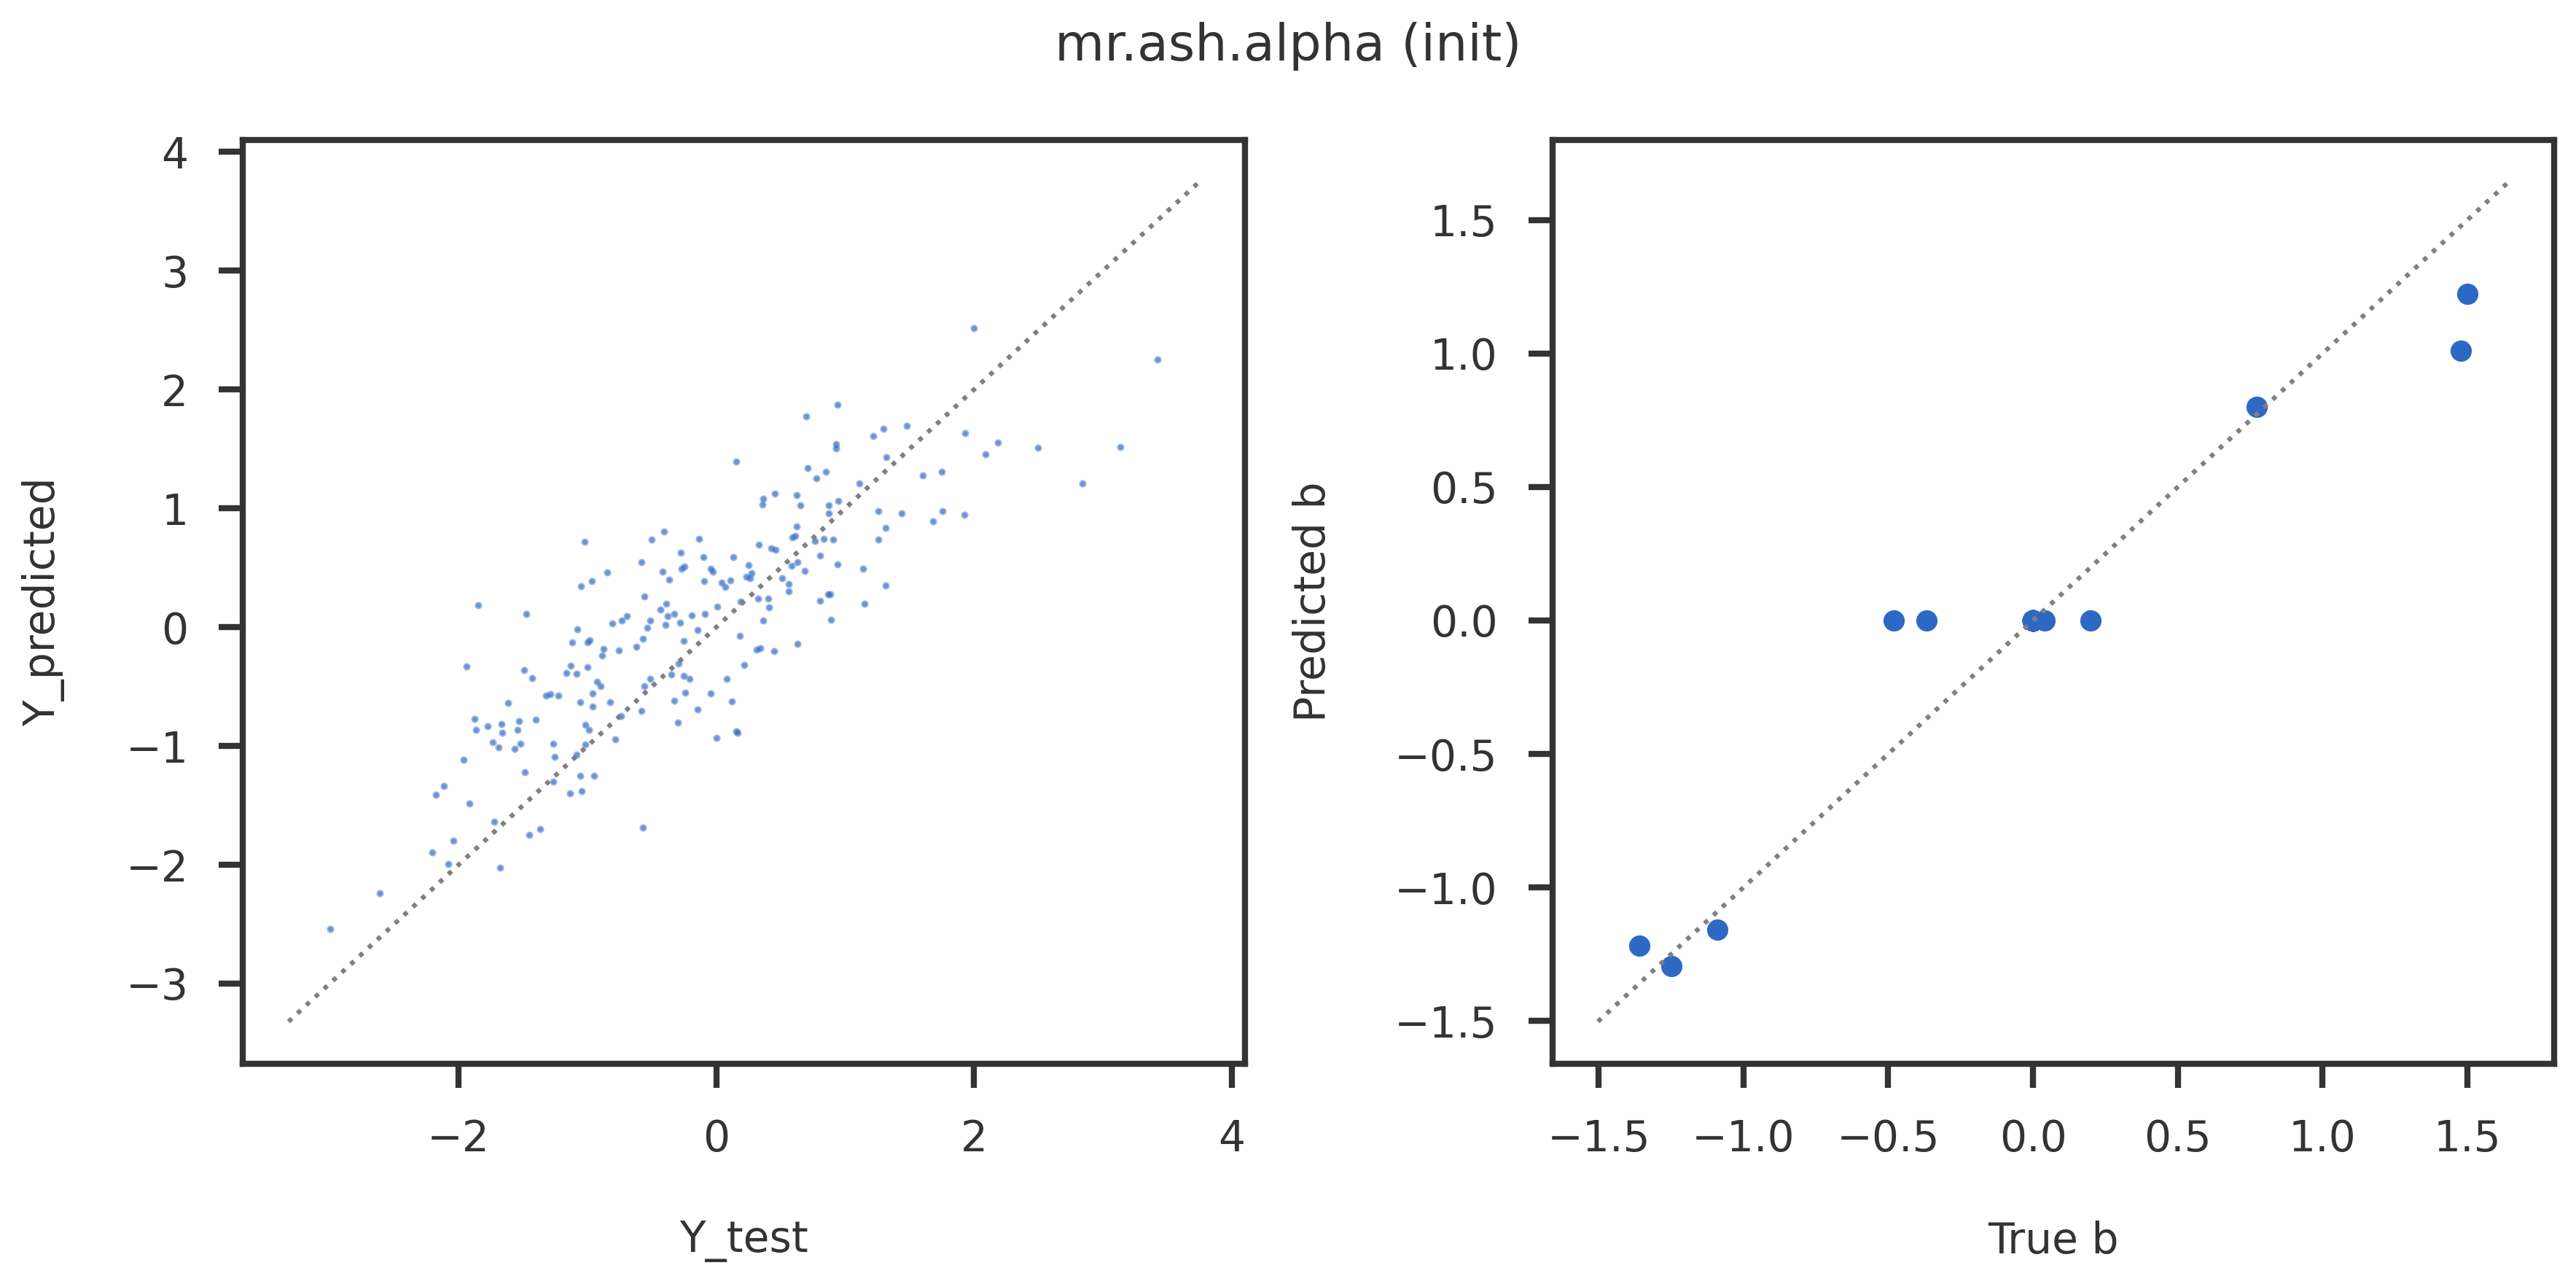

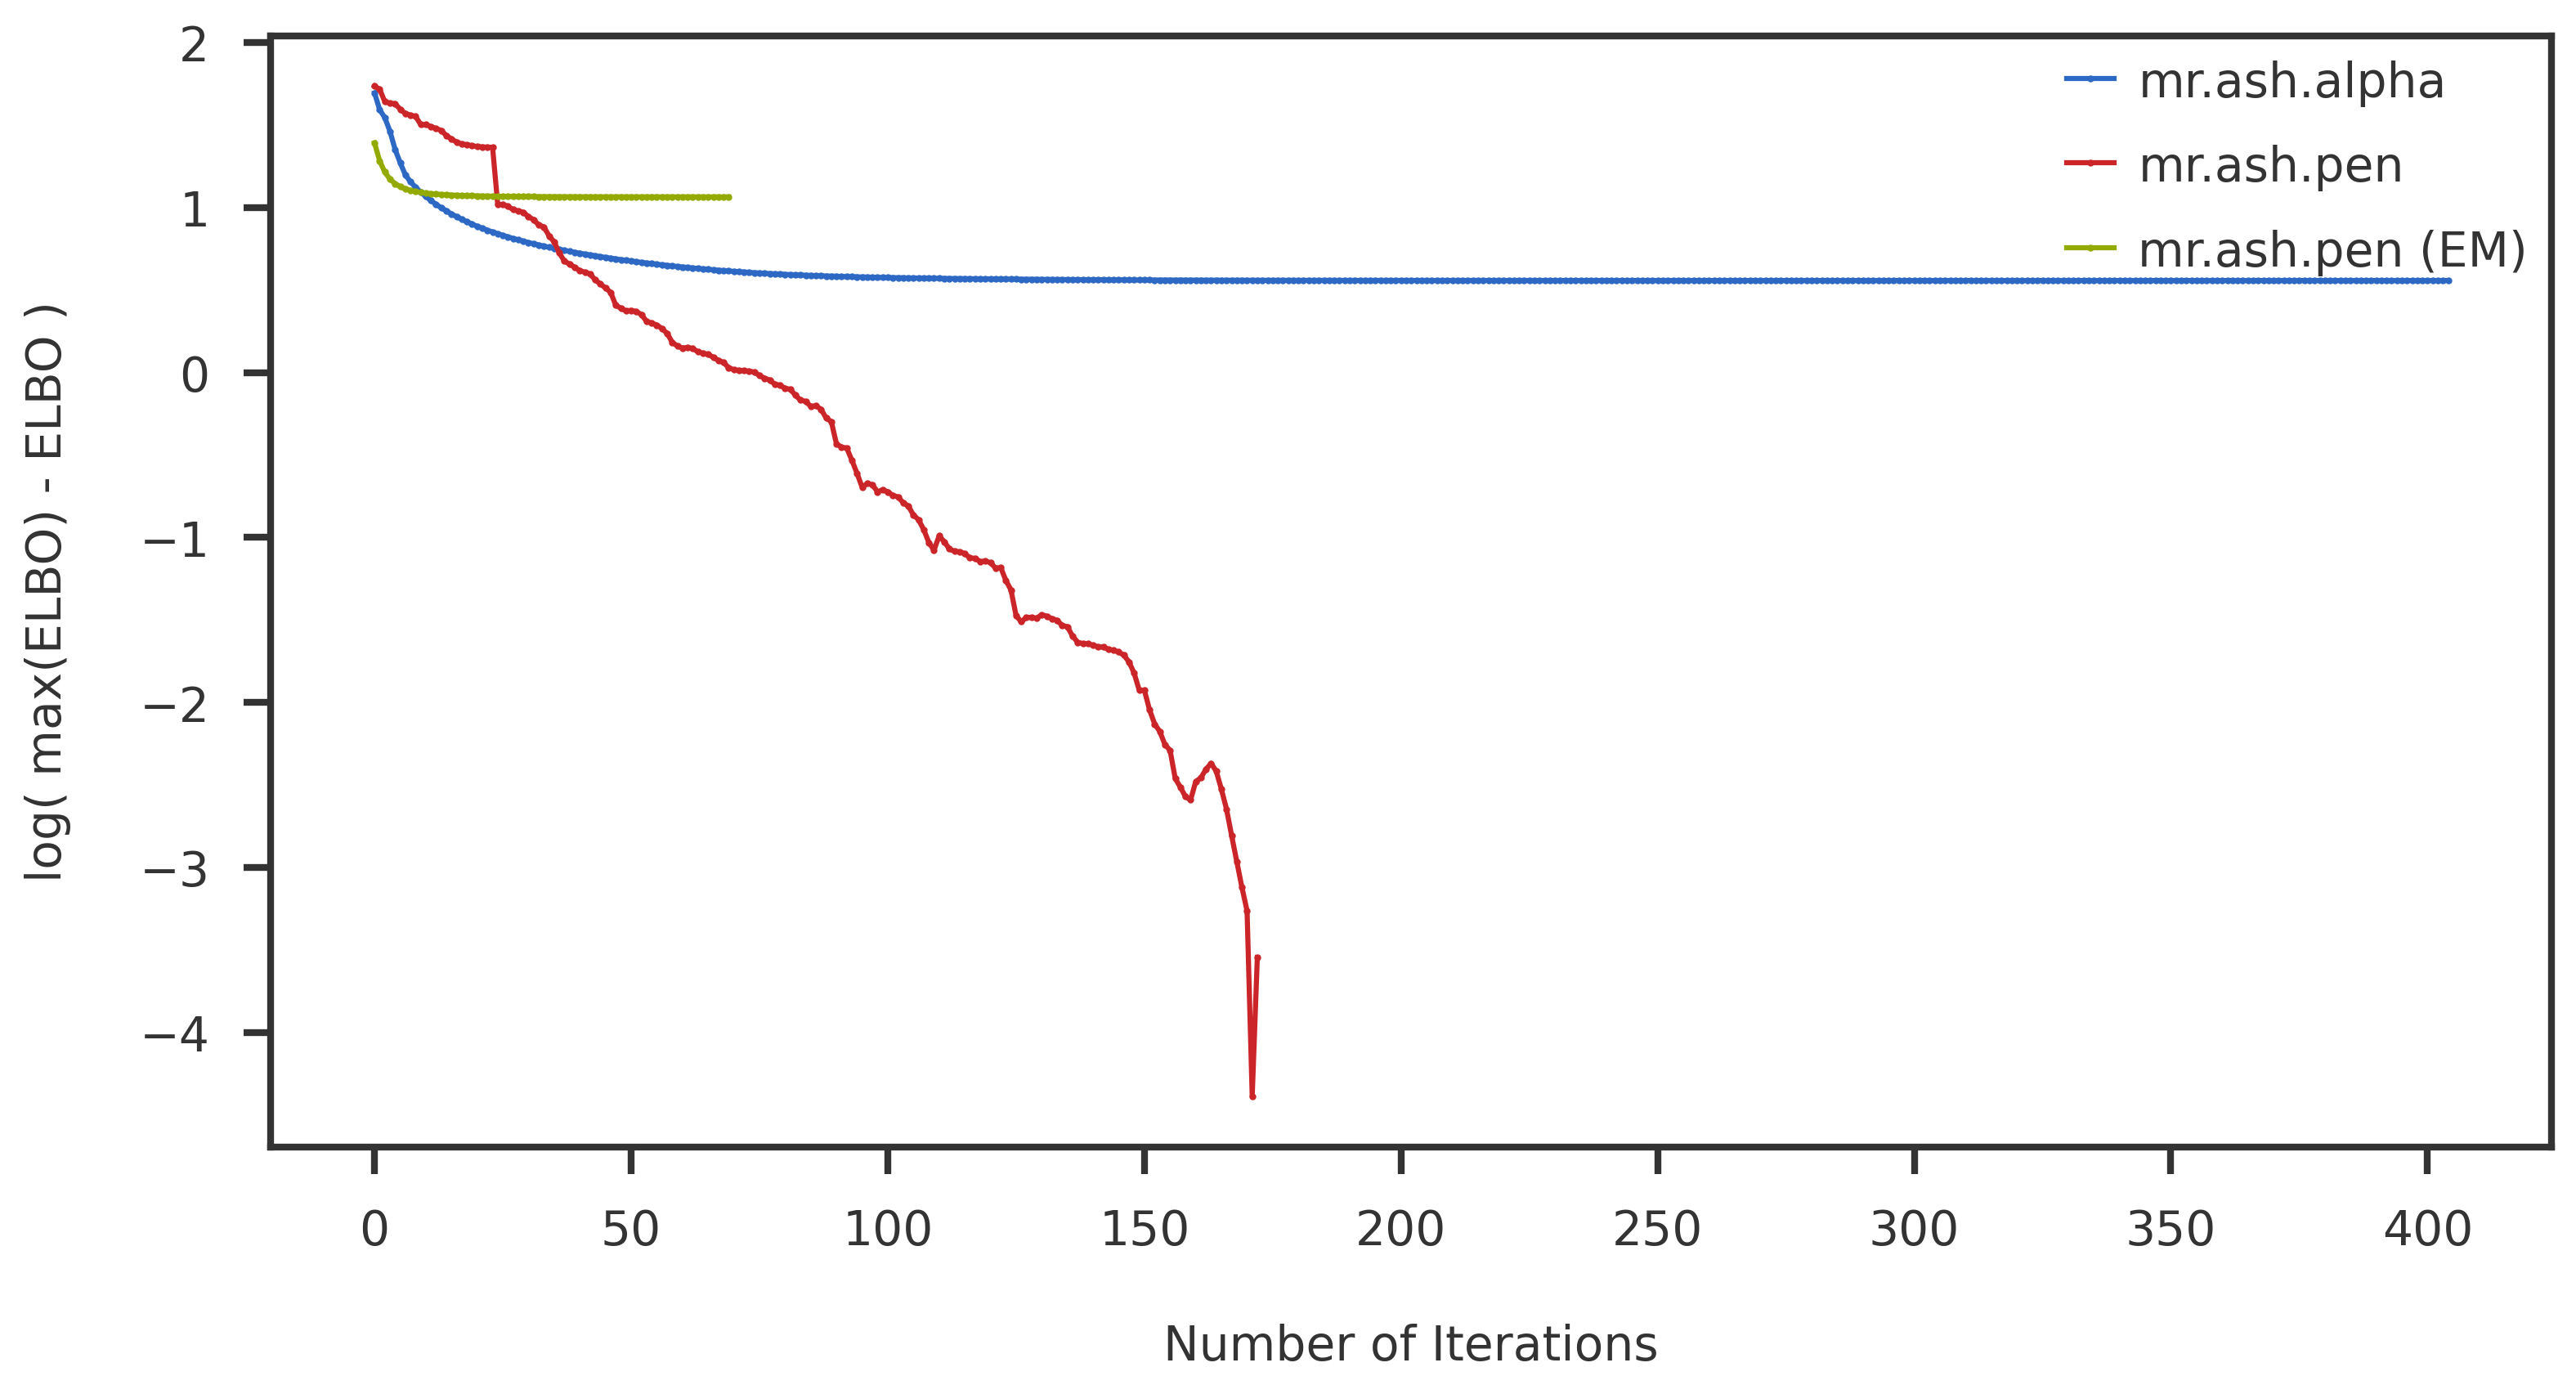

In [23]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     lasso_b, intercept = lasso_a0, title = 'Lasso')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue,
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 0, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.outer_elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
# kinit   = [0, 0, 0]
# objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path]
# methods = ["mr.ash.alpha", "mr.ash.pen"]
# kinit   = [0, 0]
# objs    = [plr_lbfgs.elbo_path, plr_eb.outer_elbo_path]
# methods = ["mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

In [30]:
wk

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [31]:
objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
# objs     = [mrash_r, plr_lbfgs, mrash_r_init]
# methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.alpha (init)"]
# df       = linreg_summary_df(strue, objs, methods)
df

,sigma2,ELBO,niter
True,0.351862,-,-
mr.ash.alpha,0.422994,261.840476,405
mr.ash.pen,0.445769,258.236207,174
mr.ash.pen (EM),0.412092,267.159756,227
mr.ash.alpha (init),0.438320,257.17008,217


In [8]:
elbo_py.scalemix(X, y, sk, plr_lbfgs.coef, plr_lbfgs.prior, plr_lbfgs.residual_var)

270.74630338412385

In [9]:
elbo_py.scalemix(X, y, sk, mrash_r.coef, mrash_r.prior, mrash_r.residual_var)

278.64767039244856

In [10]:
lasso_a0_2, lasso_b_2, _ = R_lasso.fit(X, y)
s2init_2 = np.var(y - np.dot(X, lasso_b_2) - lasso_a0_2)

lasso_a0_2, lasso_b_2, _ = R_lasso.fit(X, y)
s2init_2 = np.var(y - np.dot(X, lasso_b_2) - lasso_a0_2)

In [11]:
lasso_b[np.abs(lasso_b) > 0.01]

array([-0.20145823, -0.08784621, -0.03401665,  0.15432882,  0.49484348,
       -0.4858023 , -0.10025905, -0.05498196, -0.81646419, -0.10022639,
       -0.55376575, -0.06458629, -0.08970272, -0.13747032, -0.02980944,
       -0.09128031,  0.03681466, -0.05344504,  0.10361893, -0.02142029,
       -0.08467409,  0.13846037, -0.04776924,  0.92210451,  0.48795044,
       -0.04155721,  0.07231162, -0.21588411, -0.15507337,  0.07064637,
        0.09445026, -0.05362635,  0.11536043,  0.18702347])

In [12]:
lasso_b[np.abs(lasso_b) > 0.01]

array([-0.20145823, -0.08784621, -0.03401665,  0.15432882,  0.49484348,
       -0.4858023 , -0.10025905, -0.05498196, -0.81646419, -0.10022639,
       -0.55376575, -0.06458629, -0.08970272, -0.13747032, -0.02980944,
       -0.09128031,  0.03681466, -0.05344504,  0.10361893, -0.02142029,
       -0.08467409,  0.13846037, -0.04776924,  0.92210451,  0.48795044,
       -0.04155721,  0.07231162, -0.21588411, -0.15507337,  0.07064637,
        0.09445026, -0.05362635,  0.11536043,  0.18702347])

In [13]:
lasso_b_2[np.abs(lasso_b) > 0.01]

array([-1.81501383e-01, -6.56847661e-02, -1.95055980e-02,  1.25851055e-01,
        4.63808679e-01, -4.55466384e-01, -9.79800697e-02, -4.27908011e-02,
       -7.96306547e-01, -8.32360641e-02, -5.23167192e-01, -3.66483603e-02,
       -8.39946853e-02, -1.17098892e-01, -3.27489449e-04, -6.93486350e-02,
        0.00000000e+00, -5.14625558e-02,  6.93257489e-02,  0.00000000e+00,
       -6.65326018e-02,  1.25558964e-01, -2.90858439e-02,  8.86809066e-01,
        4.51043554e-01, -2.11213258e-02,  3.12847091e-02, -2.13604942e-01,
       -1.28315302e-01,  3.13978006e-02,  6.09327549e-02, -3.67405092e-02,
        7.44835615e-02,  1.52906083e-01])

In [14]:
s2init

0.35149136953864174

In [15]:
s2init_2

0.38737024369711803

In [18]:
%%timeit -n 1 -r 5
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = False, 
                maxiter = 2000, tol = 1e-8, function_call = 'python')
plr_lbfgs.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)

mr.ash.pen terminated at iteration 301.
mr.ash.pen terminated at iteration 301.
mr.ash.pen terminated at iteration 301.
mr.ash.pen terminated at iteration 301.
mr.ash.pen terminated at iteration 301.
3.88 s ± 122 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [19]:
%%timeit -n 1 -r 5
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = False, 
                maxiter = 2000, tol = 1e-8, function_call = 'fortran')
plr_lbfgs.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)

mr.ash.pen terminated at iteration 304.
mr.ash.pen terminated at iteration 304.
mr.ash.pen terminated at iteration 304.
mr.ash.pen terminated at iteration 304.
mr.ash.pen terminated at iteration 304.
2.64 s ± 173 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [20]:
%%timeit -n 1 -r 5
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)

Mr.ASH terminated at iteration 666.
Mr.ASH terminated at iteration 666.
Mr.ASH terminated at iteration 666.
Mr.ASH terminated at iteration 666.
Mr.ASH terminated at iteration 666.
1.81 s ± 35.6 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [14]:
# ## First step in PLR4
# wnew = plr_lbfgs.plr3.prior_path[0]
# wnew /= np.sum(wnew)
# thetanew = plr_lbfgs.plr3.theta_path[0]
# bnew = plr_lbfgs.plr3.coef_path[0]
# s2new = plr_lbfgs.plr3.s2_path[0]

# elbo0 = cd_step.elbo(X, y, sk, plr_lbfgs.plr2.coef, plr_lbfgs.plr2.prior, plr_lbfgs.plr2.residual_var)
# print (f"{elbo0:10.5f} | s, w, b from PLR2")
# elbo2 = cd_step.elbo(X, y, sk, bnew, plr_lbfgs.plr2.prior, plr_lbfgs.plr2.residual_var)
# print (f"{elbo2:10.5f} | s, w from PLR2 + b from first step of PLR3")
# elbo4 = cd_step.elbo(X, y, sk, bnew, wnew, plr_lbfgs.plr2.residual_var)
# print (f"{elbo4:10.5f} | s from PLR2 + b, w from first step of PLR3")
# elbo5 = cd_step.elbo(X, y, sk, bnew, wnew, s2new)
# print (f"{elbo5:10.5f} | s, w, b from first step of PLR2")
# print ()
# elbo1 = cd_step.elbo(X, y, sk, plr_lbfgs.plr2.coef, wnew, plr_lbfgs.plr2.residual_var)
# print (f"{elbo1:10.5f} | s, b from PLR2 + w from first step of PLR3")

# elbo3 = cd_step.elbo(X, y, sk, plr_lbfgs.plr2.coef, plr_lbfgs.plr2.prior, s2new)
# print (f"{elbo3:10.5f} | b, w from PLR2 + s from first step of PLR3")